In [1]:
# Load packages

import webknossos as wk
import matplotlib
import sys, os
import utils
sys.path.append(os.getcwd())
%load_ext autoreload
%autoreload 2

figs_dir = '/Users/atk42/OneDrive - Yale University/Kuan Lab Shared/Projects/TEM_tomo/fig_panels/'

/Users/atk42/envs/beadres/lib/python3.11/site-packages/webknossos/dataset/dataset.py:45: UserWarning: [WARNING] Not all pims readers could be imported:
	- PimsCziReader: Cannot import pylibCZIrw, please install it e.g. using pip install --extra-index-url https://pypi.scm.io/simple/ webknossos[czi]
Install the readers you need or use 'webknossos[all]' to install all readers.
  from ._utils import pims_images


In [2]:
# Define datasets to analys on WebKnossos
# Should be reconstructons of the exact same volume

my_api_token="YMtdj2_u4T2YQTn5tRHUUg"
my_url = "https://webknossos.org"
organization_id = "8632814cfac2f959"

# These are all same # of projections
datasets = [
    "MouseCerebellum_A4S1_SA3.3k_de64_tomo10_41_lim60_tomo10a_16bit",
    "15_lim21_tomo10a_16bit",
    "21_lim30_tomo10a_16bit",
    "25_lim36_tomo10a_16bit",
    '31_lim45_tomo10a_16bit',
    "35_lim51_tomo10a_16bit",           
    "41_lim60_tomo10a_16bit",
]

In [3]:
# Download annotation with beads selected
# Should be 1 skeleton with 1 node per bead

with wk.webknossos_context(url=my_url, token=my_api_token):
    annotation_id = 'https://webknossos.org/annotations/683f3db8010000d907dc85a5#1620,701,16,0,0.062,30' #'https://webknossos.org/annotations/680ba75a0100008401cd75bd#1034,1034,95,0,2,21'
    annotation = wk.Annotation.download(annotation_id)

    print(f"Downloaded annotation: {annotation.name}")


Downloaded annotation: 121_lim60_tomo10a_16bit_beads_ATK


In [4]:
# Test opting one dataset
i_dataset = 0
dataset_name = datasets[i_dataset]
print(f"Dataset: {dataset_name}")

with wk.webknossos_context(url=my_url, token=my_api_token):
    #dataset = wk.Dataset.open_remote(dataset_name)
    dataset = wk.Dataset.open_remote(dataset_name, organization_id=organization_id)
    print(f"Opened dataset: {dataset.name}")
    # 1) Whole-dataset bounding box …
    bbox = dataset.calculate_bounding_box()                # NDBoundingBox of ALL layers :contentReference[oaicite:0]{index=0}
    # 2) …or, for one specific layer:
    # bbox = ds.get_layer("color").bounding_box

    shape_x, shape_y, shape_z = bbox.size       # or: bbox.size_xyz
    print(shape_x, shape_y, shape_z)

Dataset: MouseCerebellum_A4S1_SA3.3k_de64_tomo10_41_lim60_tomo10a_16bit
Opened dataset: MouseCerebellum_A4S1_SA3.3k_de64_tomo10_41_lim60_tomo10a_16bit
2081 2077 220


## Download data before first use

In [18]:
from importlib import reload
reload(utils)

for i_dataset in range(len(datasets)):
    dataset_name = datasets[i_dataset]
    print(f"Dataset: {dataset_name}")

    with wk.webknossos_context(url=my_url, token=my_api_token):
        dataset = wk.Dataset.open_remote(dataset_name, organization_id=organization_id)
        print(f"Opened dataset: {dataset.name}")
        bounds = dataset.calculate_bounding_box()              

    annotation_points = utils.get_annotation_points(annotation)
    bounding_boxes = utils.compute_bounding_boxes_flex(annotation_points, box_size=36, dataset_shape=bounds.size)
    #bounding_boxes = utils.compute_bounding_boxes(annotation_points, box_size=36)
    subvolumes = utils.download_subvolumes_individually(
        dataset_name=dataset_name,
        bounding_boxes=bounding_boxes,
        api_token=my_api_token,
        organization_id=organization_id,
        webknossos_url=my_url
    )

    # Save after download
    file_name = f"{dataset_name}.npz"
    utils.save_subvolumes_to_npz(subvolumes, annotation_points, file_name)


Dataset: 11_lim15_tomo10a_16bit
Opened dataset: 11_lim15_tomo10a_16bit
Using layer: 11_lim15_tomo10a_16bit.tif


Saved 58 subvolumes to 11_lim15_tomo10a_16bit.npz
Dataset: 15_lim21_tomo10a_16bit
Opened dataset: 15_lim21_tomo10a_16bit
Using layer: 15_lim21_tomo10a_16bit.tif


Saved 58 subvolumes to 15_lim21_tomo10a_16bit.npz
Dataset: 21_lim30_tomo10a_16bit
Opened dataset: 21_lim30_tomo10a_16bit
Using layer: 21_lim30_tomo10a_16bit.tif


Saved 58 subvolumes to 21_lim30_tomo10a_16bit.npz
Dataset: 25_lim36_tomo10a_16bit
Opened dataset: 25_lim36_tomo10a_16bit
Using layer: 25_lim36_tomo10a_16bit.tif


Saved 58 subvolumes to 25_lim36_tomo10a_16bit.npz
Dataset: 31_lim45_tomo10a_16bit
Opened dataset: 31_lim45_tomo10a_16bit
Using layer: 31_lim45_tomo10a_16bit.tif


Saved 58 subvolumes to 31_lim45_tomo10a_16bit.npz
Dataset: 35_lim51_tomo10a_16bit
Opened dataset: 35_lim51_tomo10a_16bit
Using layer: 35_lim51_tomo10a_16bit.tif


Saved 58 subvolumes to 35_lim51_tomo10a_16bit.npz
Dataset: 41_lim60_tomo10a_16bit
Opened dataset: 41_lim60_tomo10a_16bit
Using layer: 41_lim60_tomo10a_16bit.tif


Saved 58 subvolumes to 41_lim60_tomo10a_16bit.npz


### optionally inspect a few

## Now load the pre-downloaded data

In [5]:

bead_diam_nm = 0
px_nm = 4.9
subvolumes_list = []

all_fwhms_x, all_fwhms_y, all_fwhms_z = [], [], []
all_fwhms_deconv_x, all_fwhms_deconv_y, all_fwhms_deconv_z = [], [], []
all_r2s_x, all_r2s_y, all_r2s_z = [], [], []

for i_dataset, dataset_name in enumerate(datasets):
    print(f"Processing dataset {i_dataset}: {dataset_name}")
    file_name = f"{dataset_name}.npz"
    subvolumes, annotation_points = utils.load_subvolumes_from_npz(file_name)
    subvolumes_list.append(subvolumes)
    fwhms_x, fwhms_y, fwhms_z, r2s_x, r2s_y, r2s_z = utils.compute_fwhms_from_subvolumes(subvolumes, bead_diam_nm = bead_diam_nm, 
        pixel_size_nm = px_nm, r2_cutoff = -1, linewidth = 1) #don't use r2_cutoff here to keep lengths the same
    all_fwhms_x.append(fwhms_x)
    all_fwhms_y.append(fwhms_y)
    all_fwhms_z.append(fwhms_z)

    all_r2s_z.append(r2s_z)
    all_r2s_y.append(r2s_y)
    all_r2s_x.append(r2s_x)



Processing dataset 0: 11_lim15_tomo10a_16bit
Processing dataset 1: 15_lim21_tomo10a_16bit


/Users/atk42/Repos/tem-tomo/bead_resolution/utils.py:376: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(gaussian, x, profile_1d, p0=p0)


Processing dataset 2: 21_lim30_tomo10a_16bit
Processing dataset 3: 25_lim36_tomo10a_16bit
Processing dataset 4: 31_lim45_tomo10a_16bit
Processing dataset 5: 35_lim51_tomo10a_16bit
Processing dataset 6: 41_lim60_tomo10a_16bit


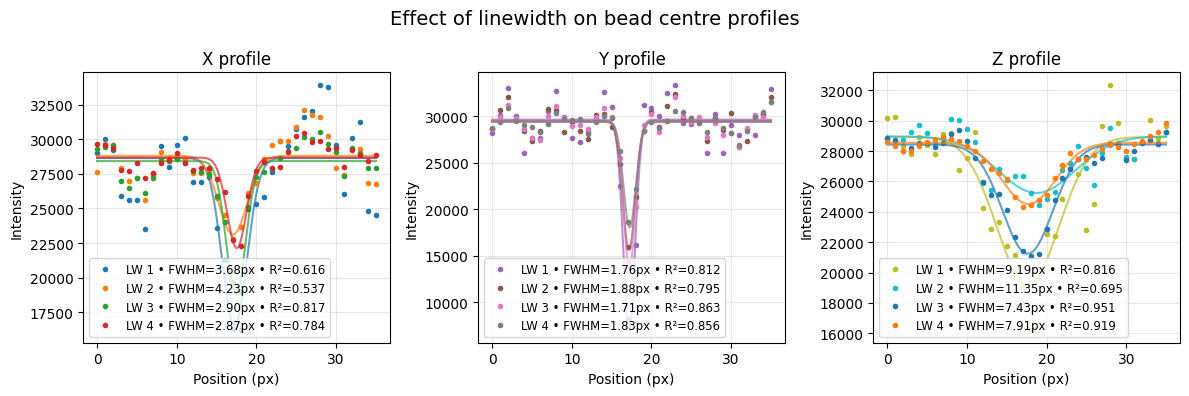

FWHM (px) and R² by axis and linewidth:
  X: LW 1 → 3.68px, R²=0.616,  LW 2 → 4.23px, R²=0.537,  LW 3 → 2.90px, R²=0.817,  LW 4 → 2.87px, R²=0.784
  Y: LW 1 → 1.76px, R²=0.812,  LW 2 → 1.88px, R²=0.795,  LW 3 → 1.71px, R²=0.863,  LW 4 → 1.83px, R²=0.856
  Z: LW 1 → 9.19px, R²=0.816,  LW 2 → 11.35px, R²=0.695,  LW 3 → 7.43px, R²=0.951,  LW 4 → 7.91px, R²=0.919


{'X': {1: (np.float64(3.6757109405640986), 0.6158325382413845),
  2: (np.float64(4.226137888453215), 0.5374734526329306),
  3: (np.float64(2.8973893895106086), 0.8172581495989767),
  4: (np.float64(2.8739603279895447), 0.7843568487707878)},
 'Y': {1: (np.float64(1.7554342344954506), 0.812386473534624),
  2: (np.float64(1.8835191394915005), 0.7950494481161541),
  3: (np.float64(1.7057590651861914), 0.8629762863307445),
  4: (np.float64(1.8329648381147516), 0.8562794617905027)},
 'Z': {1: (np.float64(9.190658511961908), 0.815533644882353),
  2: (np.float64(11.351284516749967), 0.6951060587312767),
  3: (np.float64(7.433091927529638), 0.9511910769621373),
  4: (np.float64(7.910933652243163), 0.91870720355019)}}

In [9]:
import importlib, utils
importlib.reload(utils)

vol = subvolumes[2] 
utils.plot_bead_linewidth_effect(
    vol,
    linewidths=(1,2,3,4),   # pick any set you like
    axes=("X", "Y", "Z"),      # or just ("X", "Y")
)

In [51]:
len(all_r2s_z[2])

50

Skipping: [2, 3, 5, 6, 7, 8, 9, 11, 12, 15, 17, 18, 19, 20, 24, 28, 29, 37, 38, 45, 46, 47, 48, 50, 52, 53, 54, 55, 57]


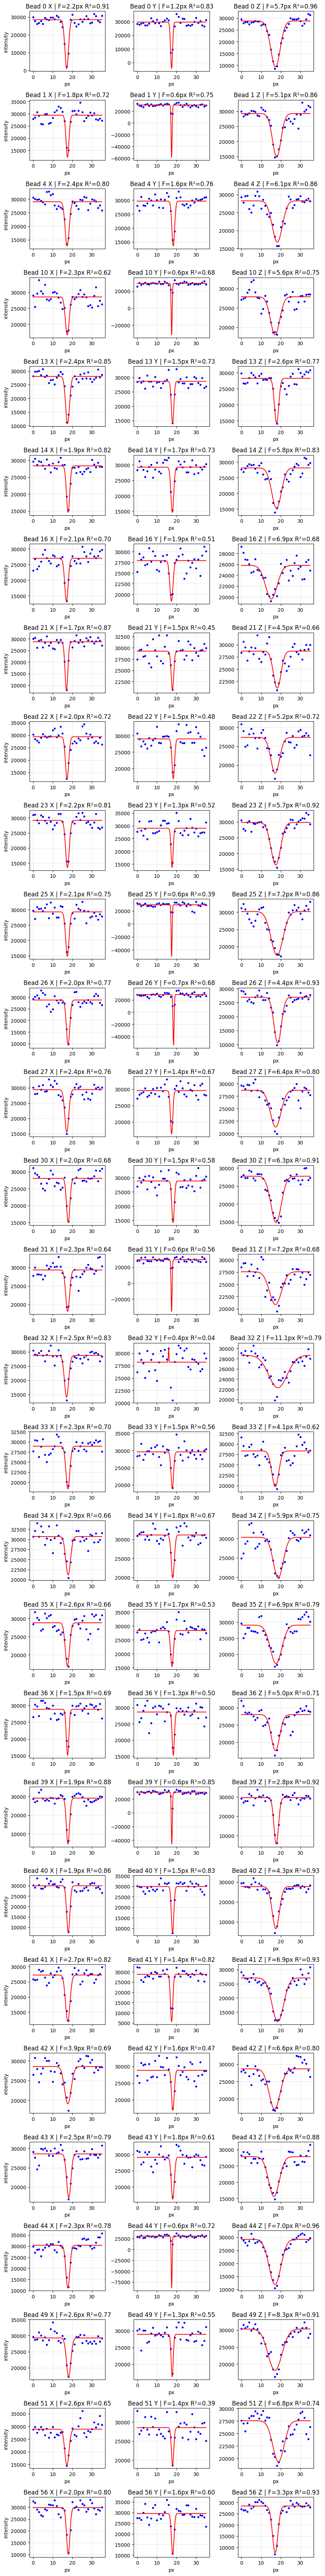

In [ ]:
# inspect fits to QC beads
import numpy as np
import importlib, utils
importlib.reload(utils)

skip_list = utils.generate_skip_bead_indices(all_r2s_x, all_r2s_z, r2_cutoff=0.6)

add_skips = []
#add_skips = [8,28,29, 4, 11,17,19,22,27,37,50,55]
zskip_list = skip_list + add_skips

# skip_pairs is a list of (dataset_idx, bead_idx)
print("Skipping:", skip_list)

utils.plot_dataset_fit_grid(
    dataset_idx=6,
    subvolumes_list=subvolumes_list,
    linewidth=1,
    skip_indices_global=skip_list,
)

/var/folders/vt/w6ggr1fn7ys7zyrbpq3d7ls5gbhsxz/T/ipykernel_60718/3701467817.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap(cmap_name, n_ds)


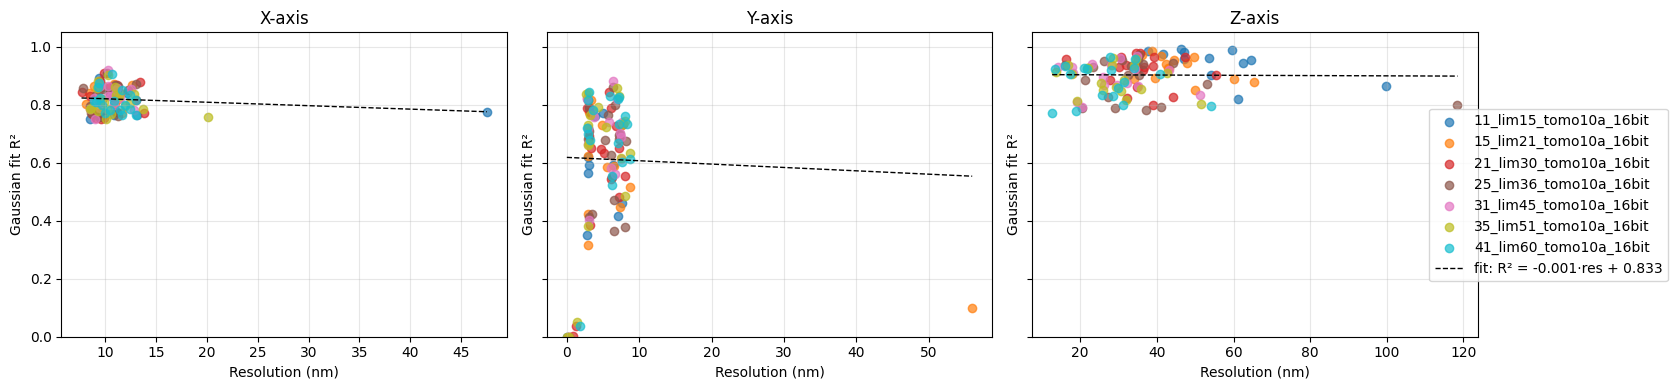

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from pathlib import Path

def plot_r2_vs_resolution(
    fwhm_lists, r2_lists, datasets, px_nm, axis_label, ax, cmap_name="tab10"
):
    """

    Scatter R² vs. resolution for a single axis on the given Matplotlib Axes.
    """
    n_ds = len(datasets)
    cmap = get_cmap(cmap_name, n_ds)

    for i_ds, (fwhms, r2s) in enumerate(zip(fwhm_lists, r2_lists)):
        # Convert to nm and filter NaNs
        res_nm = np.asarray(fwhms, dtype=float) * px_nm
        r2_arr  = np.asarray(r2s,  dtype=float)
        mask = np.isfinite(res_nm) & np.isfinite(r2_arr)
        if mask.sum() == 0:
            continue

        ax.scatter(
            res_nm[mask],
            r2_arr[mask],
            alpha=0.7,
            label=datasets[i_ds],
            color=cmap(i_ds),
        )

    # Trend line (pooled)
    all_res_nm = np.concatenate([np.asarray(lst) * px_nm for lst in fwhm_lists])
    all_r2     = np.concatenate([np.asarray(lst)        for lst in r2_lists])
    mask = np.isfinite(all_res_nm) & np.isfinite(all_r2)
    if mask.sum() > 2:
        m, b = np.polyfit(all_res_nm[mask], all_r2[mask], 1)
        xline = np.linspace(all_res_nm[mask].min(), all_res_nm[mask].max(), 100)
        ax.plot(xline, m * xline + b, "k--", lw=1, label=f"fit: R² = {m:.3f}·res + {b:.3f}")

    ax.set_xlabel("Resolution (nm)")
    ax.set_ylabel("Gaussian fit R²")
    ax.set_title(f"{axis_label}-axis")
    ax.set_ylim(0, 1.05)
    #ax.set_xlim(0, 50)
    ax.grid(True, alpha=0.3)

# ---------------- main figure ----------------
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

plot_r2_vs_resolution(all_fwhms_x, all_r2s_x, datasets, px_nm, "X", axes[0])
plot_r2_vs_resolution(all_fwhms_y, all_r2s_y, datasets, px_nm, "Y", axes[1])
plot_r2_vs_resolution(all_fwhms_z, all_r2s_z, datasets, px_nm, "Z", axes[2])

# Put a single legend to the right
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="center right", bbox_to_anchor=(1.12, 0.5))
plt.tight_layout()
plt.show()

/var/folders/vt/w6ggr1fn7ys7zyrbpq3d7ls5gbhsxz/T/ipykernel_60718/4234198674.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap(cmap_name, n_ds)


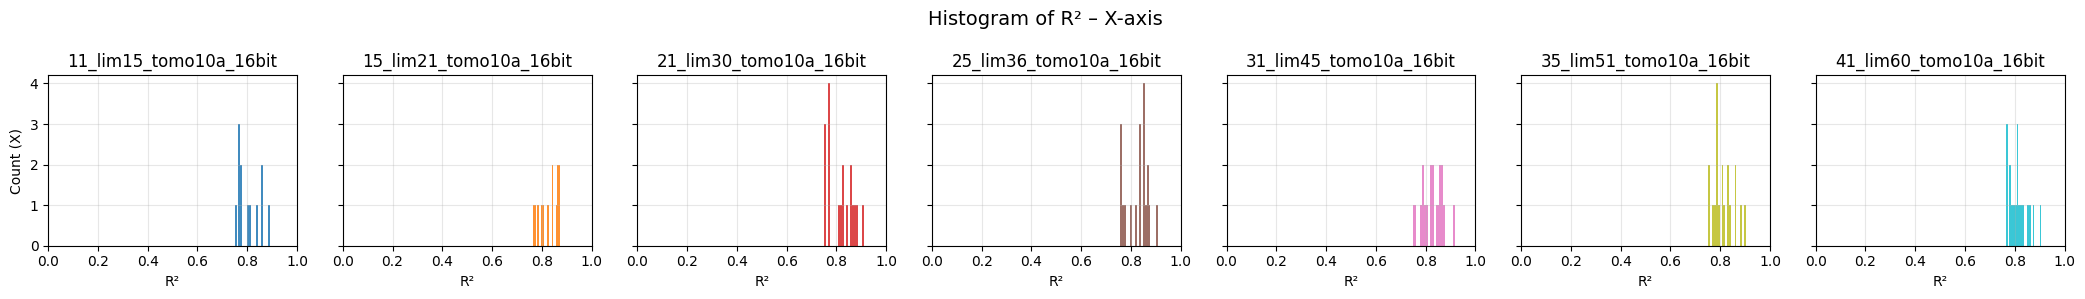

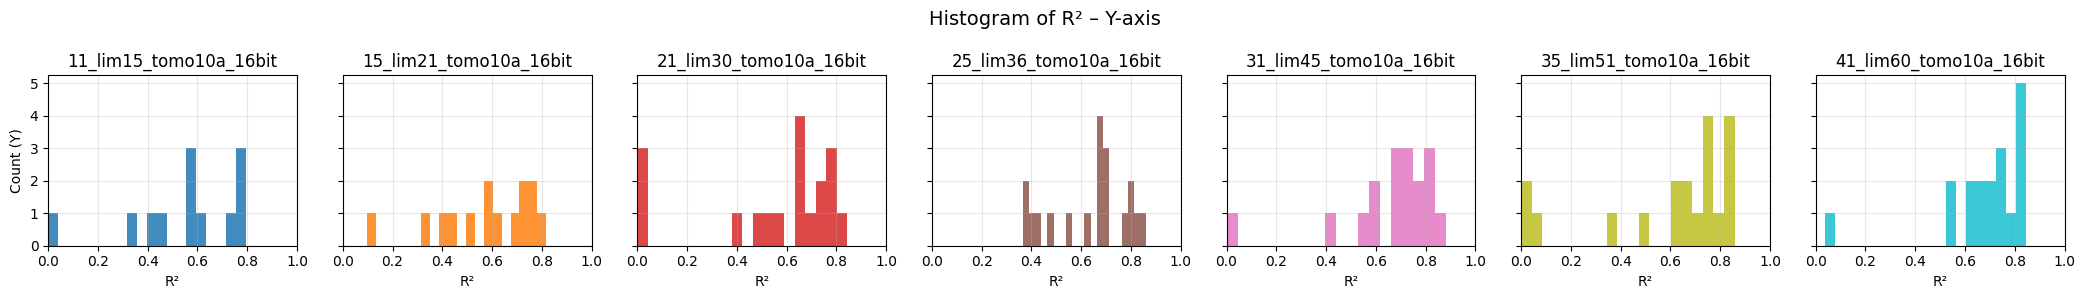

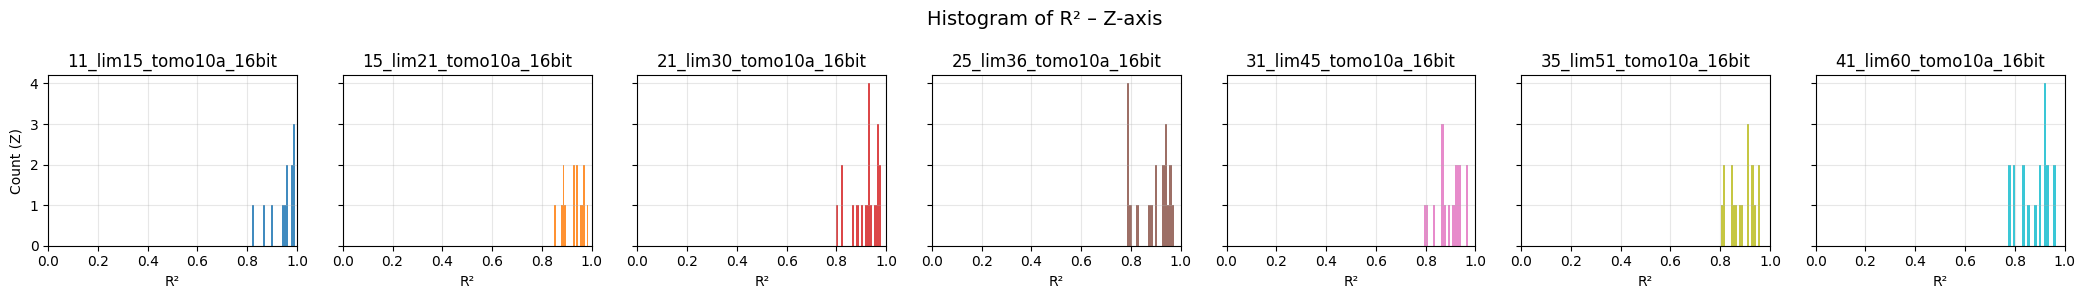

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

# ----------------------------------------------------------------------
# 1) Scatter (R² vs. resolution) — keep the helper from the previous cell
# ----------------------------------------------------------------------

def plot_r2_vs_resolution(
    fwhm_lists, r2_lists, datasets, px_nm, axis_label, ax, cmap_name="tab10"
):
    n_ds = len(datasets)
    cmap = get_cmap(cmap_name, n_ds)

    for i_ds, (fwhms, r2s) in enumerate(zip(fwhm_lists, r2_lists)):
        res_nm = np.asarray(fwhms, dtype=float) * px_nm
        r2_arr = np.asarray(r2s,   dtype=float)
        mask = np.isfinite(res_nm) & np.isfinite(r2_arr)
        if mask.sum() == 0:
            continue

        ax.scatter(res_nm[mask], r2_arr[mask], color=cmap(i_ds),
                   alpha=0.7, label=datasets[i_ds])

    # pooled trend line (optional)
    all_res = np.concatenate([np.asarray(f) * px_nm for f in fwhm_lists])
    all_r2  = np.concatenate([np.asarray(r)        for r in r2_lists])
    msk = np.isfinite(all_res) & np.isfinite(all_r2)
    if msk.sum() > 2:
        m, b = np.polyfit(all_res[msk], all_r2[msk], 1)
        xline = np.linspace(all_res[msk].min(), all_res[msk].max(), 100)
        ax.plot(xline, m * xline + b, "k--", lw=1)

    ax.set_title(f"{axis_label}-axis")
    ax.set_xlabel("Resolution (nm)")
    ax.set_ylabel("Gaussian fit R²")
    ax.set_ylim(0, 1.05)
    ax.grid(alpha=0.3)


# ----------------------------------------------------------------------
# 2) Histograms of R² per dataset & axis
# ----------------------------------------------------------------------

def plot_r2_histograms(r2_lists, datasets, axis_label, bins=20, cmap_name="tab10"):
    """
    One histogram per dataset for a given axis.
    """
    n_ds = len(datasets)
    cmap = get_cmap(cmap_name, n_ds)
    fig, axs = plt.subplots(1, n_ds, figsize=(3*n_ds, 3), sharey=True)

    for i_ds, (r2s, ax) in enumerate(zip(r2_lists, axs)):
        r2_arr = np.asarray(r2s, dtype=float)
        r2_arr = r2_arr[np.isfinite(r2_arr)]

        if r2_arr.size:
            ax.hist(r2_arr, bins=bins, color=cmap(i_ds), alpha=0.85)
        ax.set_title(datasets[i_ds])
        ax.set_xlabel("R²")
        ax.set_xlim(0, 1)
        if i_ds == 0:
            ax.set_ylabel(f"Count ({axis_label})")
        ax.grid(alpha=0.3)

    fig.suptitle(f"Histogram of R² – {axis_label}-axis", fontsize=14)
    plt.tight_layout()
    plt.show()


# ----------------------------------------------------------------------
# 3) Run the plots
# ----------------------------------------------------------------------

# ---- histograms ----
plot_r2_histograms(all_r2s_x, datasets, "X")
plot_r2_histograms(all_r2s_y, datasets, "Y")
plot_r2_histograms(all_r2s_z, datasets, "Z")

In [14]:
out_x, out_y, out_z = utils.report_fwhm_outliers(all_fwhms_x, all_fwhms_y, all_fwhms_z)


X-axis: mean=5.55, std=61.76, outliers=1
Y-axis: mean=1.41, std=2.31, outliers=9
Z-axis: mean=18.45, std=148.10, outliers=2


In [58]:
# Filter in-place: remove FWHM values > 100 from each sublist
all_fwhms_x = [[val for val in sublist if val <= 30] for sublist in all_fwhms_x]
all_fwhms_y = [[val for val in sublist if val <= 30] for sublist in all_fwhms_y]
all_fwhms_z = [[val for val in sublist if val <= 30] for sublist in all_fwhms_z]

# Filter in-place: remove FWHM values < 1 from each sublist
all_fwhms_x = [[val for val in sublist if val >= 1] for sublist in all_fwhms_x]
all_fwhms_y = [[val for val in sublist if val >= 1] for sublist in all_fwhms_y]
all_fwhms_z = [[val for val in sublist if val >= 1] for sublist in all_fwhms_z]


In [17]:
# 1) Build the skip set from your R² fits
skip_indices = utils.generate_skip_bead_indices(all_r2s_x, all_r2s_z, r2_cutoff=0.6)

# 2) Apply to every per-dataset list you want to clean
filt_fwhms_x = utils.filter_by_index_excluding(all_fwhms_x, skip_indices)
filt_fwhms_y = utils.filter_by_index_excluding(all_fwhms_y, skip_indices)
filt_fwhms_z = utils.filter_by_index_excluding(all_fwhms_z, skip_indices)


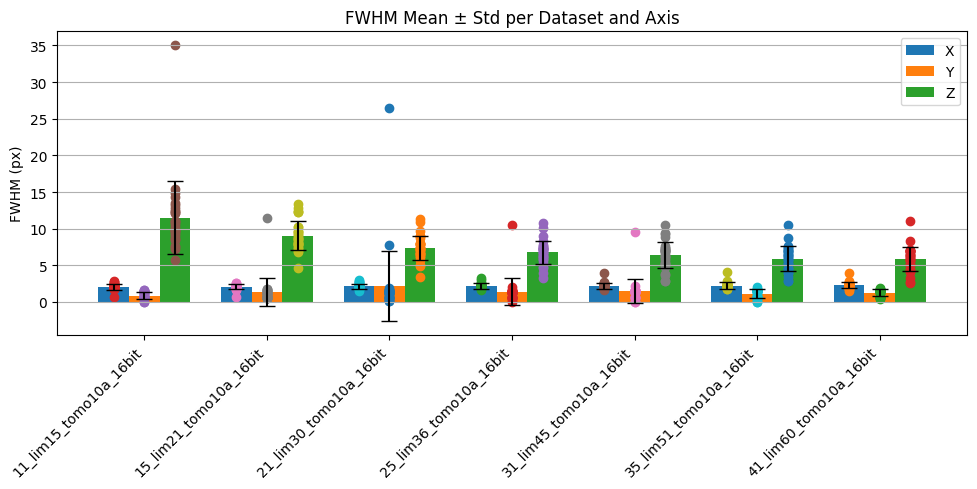

In [18]:
from importlib import reload
reload(utils)

utils.plot_fwhm_summary_by_dataset(filt_fwhms_x, filt_fwhms_y, filt_fwhms_z, dataset_names=datasets)

#plt.savefig(figs_dir + '250620_rev_Fig1g_bar_alt.pdf', bbox_inches = 'tight')

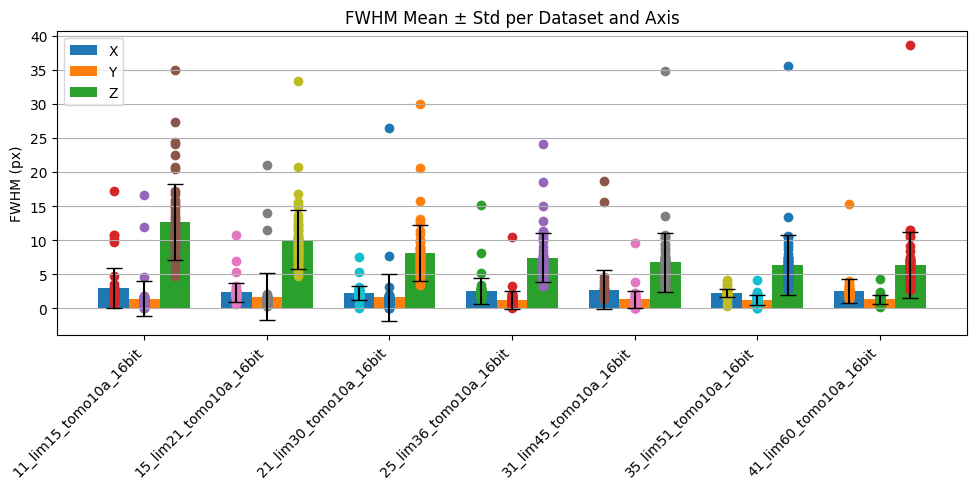

In [19]:
clean_fwhms_x, clean_fwhms_y, clean_fwhms_z = utils.remove_joint_outliers(
    all_fwhms_x, all_fwhms_y, all_fwhms_z, threshold=100.0
)

from importlib import reload
reload(utils)
utils.plot_fwhm_summary_by_dataset(clean_fwhms_x, clean_fwhms_y, clean_fwhms_z, dataset_names=datasets)


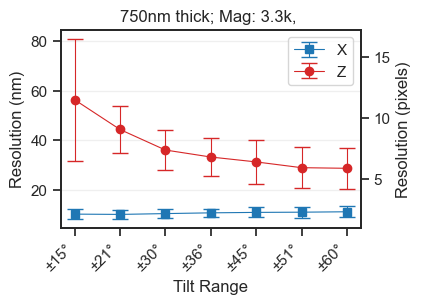

In [ ]:
# Suppose your pixel is 40 nm:

import seaborn as sns
max_angs = [15,21,30,36,45,51,60]
theta_labels = ['±%s°' % ang for ang in max_angs]



sns.set_theme(rc={'figure.figsize':(4,2),'lines.linewidth':0.8},style = 'ticks')
fig, (ax_phys, ax_px) = utils.plot_fwhm_summary_line_by_dataset(
    filt_fwhms_x,         # list of lists, X-axis FWHM in px
    filt_fwhms_z,         # same for Z
    theta_labels,
    pixel_size=4.9,    # 0.040 µm = 40 nm
    pixel_unit="nm"      # or let it infer
)

#plt.legend().remove()
ax_phys.set_xlabel('Tilt Range')
ax_phys.set_ylabel('Resolution (nm)')
ax_px.set_ylabel('Resolution (pixels)')
ax_phys.set_title('750nm thick; Mag: %s, ' % '3.3k')
#ax_phys.set_xticks(max_angs)
ax_phys.set_xticklabels(theta_labels) # Need to fix spacing!
plt.savefig(figs_dir + '250821_rev_Fig1g_beads.pdf', bbox_inches = 'tight')

/var/folders/vt/w6ggr1fn7ys7zyrbpq3d7ls5gbhsxz/T/ipykernel_2083/582006380.py:82: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


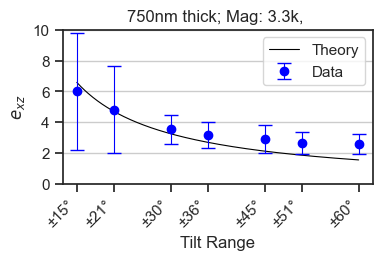

In [37]:
import re
import numpy as np
import matplotlib.pyplot as plt
import math 
# Extract angles from dataset names
def extract_angle(name):
    match = re.search(r'lim(\d+)', name)
    return int(match.group(1)) if match else None

# --- Compute empirical e_xz = FWHM_z / FWHM_y per dataset ---
def empirical_ratio_and_std(fwhms_z, fwhms_y, clip_max=100.0):
    """
    Compute mean/std of FWHM_z / FWHM_y while filtering bad values:
    - removes NaNs
    - removes zero or near-zero denominators
    - clips extreme FWHMs above `clip_max`
    """
    z = np.array(fwhms_z)
    y = np.array(fwhms_y)

    # Clean both numerator and denominator
    valid_mask = (
        ~np.isnan(z) & ~np.isnan(y) &
        (y > 0.1) & (z < clip_max) & (y < clip_max)
    )
    z_clean = z[valid_mask]
    y_clean = y[valid_mask]

    if len(z_clean) == 0:
        return np.nan, np.nan

    ratios = z_clean / y_clean
    return np.nanmean(ratios), np.nanstd(ratios)
# --- Theoretical Rademacher function ---
def calculate_e_xz(alpha_deg):
    alpha_rad = math.radians(alpha_deg)
    num = alpha_rad + math.sin(alpha_rad) * math.cos(alpha_rad)
    den = alpha_rad - math.sin(alpha_rad) * math.cos(alpha_rad)
    if den == 0:
        return np.nan
    return math.sqrt(num / den)

angles = [extract_angle(name) for name in datasets]
dataset_labels = datasets

# Compute empirical e_xz for each dataset USING X not Y
e_means = []
e_stds = []

for name in datasets:
    idx = datasets.index(name)
    mean, std = empirical_ratio_and_std(filt_fwhms_z[idx], filt_fwhms_x[idx])
    e_means.append(mean)
    e_stds.append(std)

# Theoretical curve
alpha_curve = np.linspace(15, 60, 300)
e_theory = [calculate_e_xz(a) for a in alpha_curve]

# Plot
sns.set_theme(rc={'figure.figsize':(4,2),'lines.linewidth':0.8},style = 'ticks')
plt.plot(alpha_curve, e_theory, label='Theory', color='black')

max_angs = [15,21,30,36,45,51,60]
theta_labels = ['±%s°' % ang for ang in max_angs]

# Empirical data
plt.errorbar(
    angles, e_means, yerr=e_stds, fmt='o', capsize=5, markersize=6,
    label='Data', color='blue'
)

# X-axis with dataset labels at angle ticks
plt.xticks(angles, dataset_labels, rotation=45, ha='right')
plt.xlabel('Tilt Range')
plt.ylim([0,10])
plt.ylabel(r'$e_{xz}$')

plt.title('750nm thick; Mag: %s, ' % '3.3k')
plt.legend(loc='upper right')
plt.grid(True, axis='y')
plt.tight_layout()

#plt.show()

plt.xticks(max_angs, theta_labels)
plt.savefig(figs_dir + '250821_rev_Fig1g_alt.pdf', bbox_inches = 'tight')

In [37]:
outliers = utils.find_outlier_beads(
    subvolumes,
    fwhm_threshold_px=20,
    r2_cutoff=0.7,
    linewidth=1
)

print(f"Found {len(outliers)} suspect beads:", [o['idx'] for o in outliers])

# 2) visualise
utils.plot_outlier_bead_fits(
    subvolumes,
    outliers,
    linewidth=1,
)

AttributeError: module 'utils' has no attribute 'find_outlier_beads'

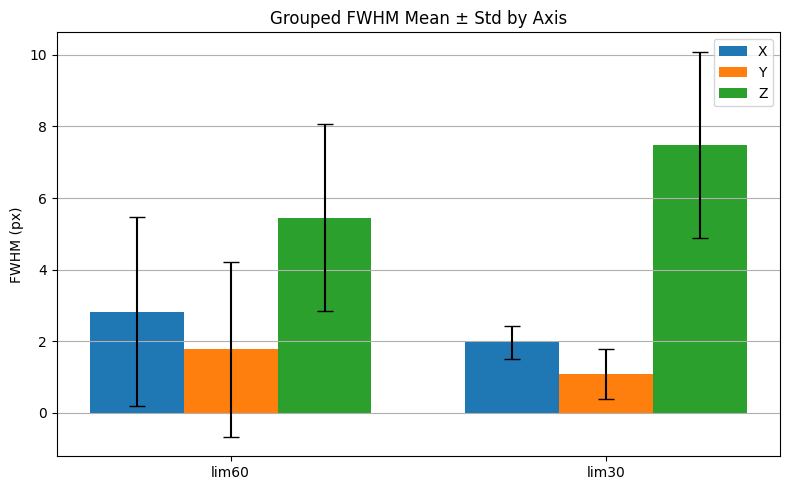

In [ ]:
# group_labels = {
#     'lim60': ['lim60'],
#     'lim30': ['lim30']
# }

# utils.plot_fwhm_summary(
#     all_fwhms_x, all_fwhms_y, all_fwhms_z,
#     dataset_names=datasets,
#     group_labels=group_labels
# )


In [ ]:
fwhms_z = []
fwhms_y = []
fwhms_x = []

for i, vol in enumerate(subvolumes):
    z, y, x = vol.shape

    profile_z = vol[:, y//2, x//2]
    profile_y = vol[z//2, :, x//2]
    profile_x = vol[z//2, y//2, :]

    fwhm_z, _ = utils.fit_gaussian_and_compute_fwhm(profile_z)
    fwhm_y, _ = utils.fit_gaussian_and_compute_fwhm(profile_y)
    fwhm_x, _ = utils.fit_gaussian_and_compute_fwhm(profile_x)

    fwhms_z.append(fwhm_z)
    fwhms_y.append(fwhm_y)
    fwhms_x.append(fwhm_x)


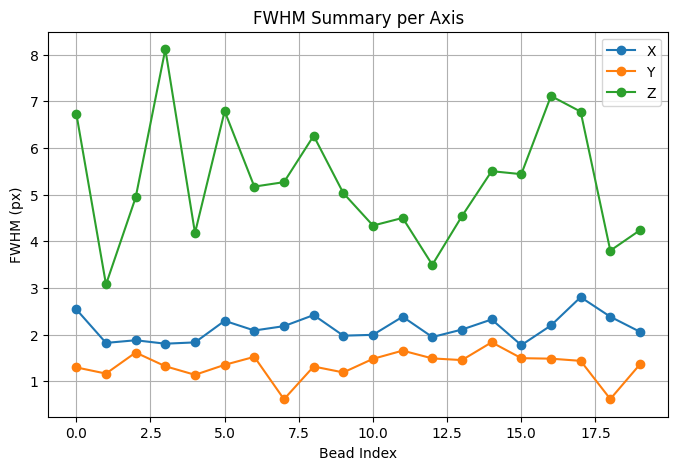

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(fwhms_x, 'o-', label='X')
plt.plot(fwhms_y, 'o-', label='Y')
plt.plot(fwhms_z, 'o-', label='Z')
plt.xlabel('Bead Index')
plt.ylabel('FWHM (px)')
plt.title('FWHM Summary per Axis')
plt.grid(True)
plt.legend()
plt.show()
